1. 基础题
   - 使用三种时序差分价值迭代方法（SARSA，期望 SARSA，Q 学习）求解悬崖寻路策略 CliffWalking-v0
   - 随机数种子为学号后四位
   - 自行对超参数寻优
   - 训练好后，输出三种方法完全利用（epsilon=0）时的回合总奖励（total_reward）（评分比重70%）
   - 将代码和结果整理为ipynb格式（文件名“MTA.ipynb”），需要包含三种方法训练过程中每个回合的总奖励变化曲线（评分比重30%）

In [1]:
import numpy as np
import gym

np.random.seed(5235) # 学号后四位

### 环境使用

引入环境

In [2]:
env = gym.make('CliffWalking-v0')
env.seed(523)
print('观测空间 = {}'.format(env.observation_space))
print('动作空间 = {}'.format(env.action_space))
print('状态数量 = {}, 动作数量 = {}'.format(env.nS, env.nA))
print('地图大小 = {}'.format(env.shape))

观测空间 = Discrete(48)
动作空间 = Discrete(4)
状态数量 = 48, 动作数量 = 4
地图大小 = (4, 12)


/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-packages/gym/core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(


单回合测试

In [3]:
def play_once(env, policy):
    total_reward = 0
    state = env.reset()
    while True:
        loc = np.unravel_index(state, env.shape)
        print('状态 = {}, 位置 = {}'.format(state, loc), end=' ')
        action = np.random.choice(env.nA, p=policy[state])
        next_state, reward, done, _ = env.step(action)
        print('动作 = {}, 奖励 = {}, 次态 = {}'.format(action, reward, next_state))
        total_reward += reward
        if done:
            break
        state = next_state
    return total_reward

目标：最优策略

In [4]:
actions = np.ones(env.shape, dtype=int)
actions[-1, :] = 0
actions[:, -1] = 2
optimal_policy = np.eye(4)[actions.reshape(-1)]
total_reward = play_once(env, optimal_policy)
print('回合奖励 = {}'.format(total_reward))

状态 = 36, 位置 = (3, 0) 动作 = 0, 奖励 = -1, 次态 = 24
状态 = 24, 位置 = (2, 0) 动作 = 1, 奖励 = -1, 次态 = 25
状态 = 25, 位置 = (2, 1) 动作 = 1, 奖励 = -1, 次态 = 26
状态 = 26, 位置 = (2, 2) 动作 = 1, 奖励 = -1, 次态 = 27
状态 = 27, 位置 = (2, 3) 动作 = 1, 奖励 = -1, 次态 = 28
状态 = 28, 位置 = (2, 4) 动作 = 1, 奖励 = -1, 次态 = 29
状态 = 29, 位置 = (2, 5) 动作 = 1, 奖励 = -1, 次态 = 30
状态 = 30, 位置 = (2, 6) 动作 = 1, 奖励 = -1, 次态 = 31
状态 = 31, 位置 = (2, 7) 动作 = 1, 奖励 = -1, 次态 = 32
状态 = 32, 位置 = (2, 8) 动作 = 1, 奖励 = -1, 次态 = 33
状态 = 33, 位置 = (2, 9) 动作 = 1, 奖励 = -1, 次态 = 34
状态 = 34, 位置 = (2, 10) 动作 = 1, 奖励 = -1, 次态 = 35
状态 = 35, 位置 = (2, 11) 动作 = 2, 奖励 = -1, 次态 = 47
回合奖励 = -13


# SARSA

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
class SARSAAgent:
    def __init__(self, env, gamma=0.9, learning_rate=0.5, epsilon=.1):
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.action_n = env.action_space.n
        self.q = np.zeros((env.observation_space.n, env.action_space.n))
        
    def decide(self, state):
        if np.random.uniform() > self.epsilon:
            action = self.q[state].argmax()
        else:
            action = np.random.randint(self.action_n)
        return action
    
    def learn(self, state, action, reward, next_state, done, next_action):
        u = reward + self.gamma * \
                self.q[next_state, next_action] * (1. - done)
        td_error = u - self.q[state, action]
        self.q[state, action] += self.learning_rate * td_error

In [7]:
def play_sarsa(env, agent, train=False, render=False):
    episode_reward = 0
    observation = env.reset()
    action = agent.decide(observation)
    while True:
        if render:
            env.render()
        next_observation, reward, done, _ = env.step(action)
        episode_reward += reward
        next_action = agent.decide(next_observation) # 终止状态时此步无意义
        if train:
            agent.learn(observation, action, reward, next_observation,
                    done, next_action)
        if done:
            break
        observation, action = next_observation, next_action
    return episode_reward

平均回合奖励 = -1700 / 100 = -17.0


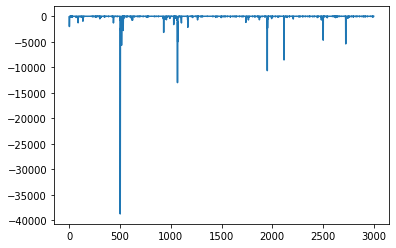

In [8]:
agent = SARSAAgent(env)

# 训练
episodes = 3000
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_sarsa(env, agent, train=True)
    episode_rewards.append(episode_reward)
    
plt.plot(episode_rewards)

# 测试
agent.epsilon = 0. # 取消探索

episode_rewards = [play_sarsa(env, agent) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

# Expectaion-SARSA

In [9]:
class ExpectedSARSAAgent:
    def __init__(self, env, gamma=0.9, learning_rate=0.1, epsilon=.01):
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.q = np.zeros((env.observation_space.n, env.action_space.n))
        self.action_n = env.action_space.n
        
    def decide(self, state):
        if np.random.uniform() > self.epsilon:
            action = self.q[state].argmax()
        else:
            action = np.random.randint(self.action_n)
        return action
    
    def learn(self, state, action, reward, next_state, done):
        v = (self.q[next_state].mean() * self.epsilon + \
                self.q[next_state].max() * (1. - self.epsilon))
        u = reward + self.gamma * v * (1. - done)
        td_error = u - self.q[state, action]
        self.q[state, action] += self.learning_rate * td_error

In [10]:
def play_qlearning(env, agent, train=False, render=False):
    episode_reward = 0
    observation = env.reset()
    while True:
        if render:
            env.render()
        action = agent.decide(observation)
        next_observation, reward, done, _ = env.step(action)
        episode_reward += reward
        if train:
            agent.learn(observation, action, reward, next_observation,
                    done)
        if done:
            break
        observation = next_observation
    return episode_reward

平均回合奖励 = -1500 / 100 = -15.0


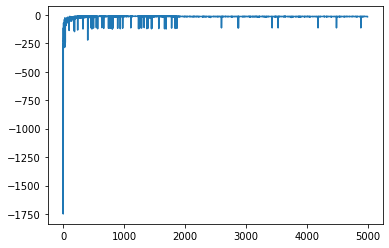

In [11]:
agent = ExpectedSARSAAgent(env)

# 训练
episodes = 5000
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_qlearning(env, agent, train=True)
    episode_rewards.append(episode_reward)
    
plt.plot(episode_rewards)

# 测试
agent.epsilon = 0. # 取消探索

episode_rewards = [play_qlearning(env, agent) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

# Q-Learning

In [12]:
class QLearningAgent:
    def __init__(self, env, gamma=0.9, learning_rate=0.1, epsilon=.1):
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.action_n = env.action_space.n
        self.q = np.zeros((env.observation_space.n, env.action_space.n))
        
    def decide(self, state):
        if np.random.uniform() > self.epsilon:
            action = self.q[state].argmax()
        else:
            action = np.random.randint(self.action_n)
        return action
    
    def learn(self, state, action, reward, next_state, done):
        u = reward + self.gamma * self.q[next_state].max() * (1. - done)
        td_error = u - self.q[state, action]
        self.q[state, action] += self.learning_rate * td_error

平均回合奖励 = -1300 / 100 = -13.0


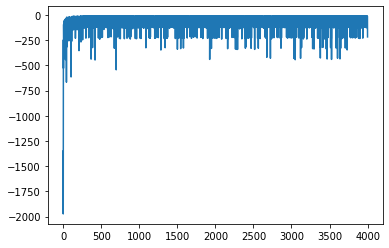

In [13]:
agent = QLearningAgent(env)

# 训练
episodes = 4000
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_qlearning(env, agent, train=True)
    episode_rewards.append(episode_reward)
    
plt.plot(episode_rewards)

# 测试
agent.epsilon = 0. # 取消探索

episode_rewards = [play_qlearning(env, agent) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))